<a href="https://colab.research.google.com/github/azrizalg/azrizalg/blob/main/covid_case_pred_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovery = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
df_dataLokasi = pd.read_csv('https://drive.google.com/uc?export=download&id=1oSPiGpmAW08DnYPk0xg03fDwdKZduZOF')
df_case = pd.read_csv(url_case)
df_death = pd.read_csv(url_death)
df_recovery = pd.read_csv(url_recovery)

In [ ]:
df_case = df_case.drop(['Province/State', 'Lat','Long'], axis=1)
df_case = df_case.groupby(['Country/Region']).sum() #karena terdapat region yang double
df_case = df_case.transpose().reset_index()
df_case = pd.melt(df_case,id_vars=['index'])
df_case.rename(columns={'value': 'total_cases'}, inplace=True)

df_death = df_death.drop(['Province/State', 'Lat','Long'], axis=1)
df_death = df_death.groupby(['Country/Region']).sum()
df_death = df_death.transpose().reset_index()
df_death = pd.melt(df_death,id_vars=['index'])
df_death.rename(columns={'value': 'total_deaths'}, inplace=True)#inplace = dataframe di replace langsung

df_recovery = df_recovery.drop(['Province/State', 'Lat','Long'], axis=1)
df_recovery = df_recovery.groupby(['Country/Region']).sum()
df_recovery = df_recovery.transpose().reset_index()
df_recovery = pd.melt(df_recovery,id_vars=['index'])
df_recovery.rename(columns={'value': 'total_recoveries'}, inplace=True)

#merge ketiga dataframe diatas menjadi satu
dataset = pd.merge(df_case, df_death, on=['index','Country/Region'])
dataset = pd.merge(dataset, df_recovery, on=['index','Country/Region'])
dataset.rename(columns={'index': 'tanggal'}, inplace=True)
dataset['tanggal'] = pd.to_datetime(dataset['tanggal'])#ubah format kolom tanggal dari obj ke datetime
df = dataset.groupby(['tanggal']).sum().reset_index()# digabung berdasarkan tanggalnya

In [ ]:
#kasus
df['new_cases'] = df['total_cases'] - df['total_cases'].shift(+1, fill_value=0)#memasukkan selisih kasus dengan hari sebelumnya
#df['new_cases'][df['new_cases'] < 0] = 0 #menghilangkan nilai negatif yang dihasilkan dari kode diatas

#kematian
df['new_deaths'] = df['total_deaths'] - df['total_deaths'].shift(+1, fill_value=0)
#df['new_deaths'][df['new_deaths'] < 0] = 0 #menghilangkan nilai negatif yang dihasilkan dari kode diatas

#recovery
df['new_recoveries'] = df['total_recoveries'] - df['total_recoveries'].shift(+1, fill_value=0)

#remove value negative
col = ['new_cases','new_deaths','new_recoveries']
df[col] = df[col].clip(lower=0)

In [ ]:
df

,tanggal,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries
0,2020-01-22,557,17,30,557,17,30
1,2020-01-23,655,18,32,98,1,2
2,2020-01-24,941,26,39,286,8,7
3,2020-01-25,1433,42,42,492,16,3
4,2020-01-26,2118,56,56,685,14,14
...,...,...,...,...,...,...,...
502,2021-06-07,173631266,3736513,111567881,320618,8062,421868
503,2021-06-08,173997437,3746919,111982400,366171,10406,414519
504,2021-06-09,174416271,3757343,112434908,418834,10424,452508
505,2021-06-10,174865276,3773339,112848412,449005,15996,413504


In [ ]:
data_case = df[['tanggal', 'new_cases']]

In [ ]:
data_case['tanggal'] = pd.to_datetime(data_case['tanggal'])
data_case.set_index(['tanggal'], inplace=True)
data_case = data_case.asfreq(freq='D')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(df.isnull().any())

tanggal             False
total_cases         False
total_deaths        False
total_recoveries    False
new_cases           False
new_deaths          False
new_recoveries      False
dtype: bool


In [ ]:
panjang = len(data_case)
train = data_case.iloc[:panjang-21]
test = data_case.iloc[panjang-21:]

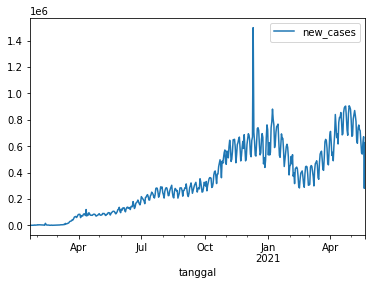

In [ ]:
train.plot()

## Scalling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## generator

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
n_input = 21
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [ ]:
model = Sequential()

model.add(LSTM(150, activation="relu", input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(train_generator, epochs=55)

Epoch 1/55


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


233/233 [==============================] - 5s 15ms/step - loss: 0.0119
Epoch 2/55
233/233 [==============================] - 3s 15ms/step - loss: 0.0029
Epoch 3/55
233/233 [==============================] - 3s 15ms/step - loss: 0.0032
Epoch 4/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0025
Epoch 5/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0032
Epoch 6/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0022
Epoch 7/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0020
Epoch 8/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0039
Epoch 9/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0019
Epoch 10/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0043
Epoch 11/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0039
Epoch 12/55
233/233 [==============================] - 3s 14ms/step - loss: 0.0031
Epoch 13/55
233/233 [===

In [ ]:
model.history.history.keys()

dict_keys(['loss'])

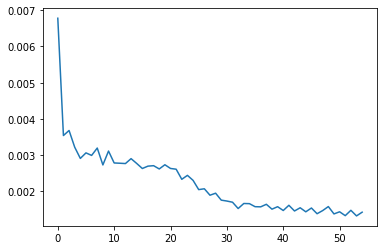

In [ ]:
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), myloss)

In [ ]:
test_prediction = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(21):
  #predict 1 step ahead
  current_prediction = model.predict(current_batch)[0]

  #store the prediction
  test_prediction.append(current_prediction)

  #update current batch to include the prediction
  current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

In [ ]:
finalpred = scaler.inverse_transform(test_prediction)

In [ ]:
test['Predictions'] = finalpred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


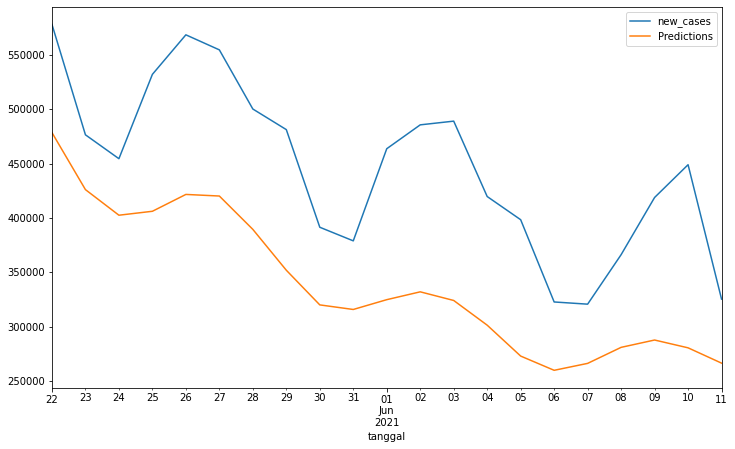

In [ ]:
test.plot(figsize=(12, 7))